In [278]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("dark")

In [279]:
# Load the MNIST dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5)),
     ])

mnist = MNIST(root=".", download=True, transform=transform)
mnist_test = MNIST(root=".", download=True, train=False, transform=transform)

# Create a data loader to iterate over the dataset
data_loader = DataLoader(mnist, batch_size=128, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=1, shuffle=True)

In [338]:
# VAE

# 28x28 -> 7x7
class Encoder(nn.Module):
    def __init__(self, input_ch, hidden_ch, latent_ch=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_ch, hidden_ch, kernel_size=5, stride=2, 
                               padding=2) # 28x28 -> 14x14
        self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2) # 7x7
        self.conv_mu = nn.Conv2d(hidden_ch, latent_ch, kernel_size=3, padding=1)
        self.conv_sigma = nn.Conv2d(hidden_ch, latent_ch, kernel_size=3, padding=1)

        self.do1 = nn.Dropout(0.1)
        self.do2 = nn.Dropout(0.1)
        self.activ = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(self.do1(self.activ(x)))
        x = self.pool(self.do2(self.activ(x)))
        mu = self.conv_mu(x)
        sigma = torch.exp(self.conv_sigma(x))

        return mu, sigma

class Decoder(nn.Module):
  #hidden_out-> hidden -> 28*28 
    def __init__(self, output_ch, hidden_ch, latent_ch=1):
        super().__init__()
        self.conv1 = nn.Conv2d(latent_ch, hidden_ch, kernel_size=3, padding=1)
        self.upsample = nn.UpsamplingNearest2d(scale_factor=2)
        self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, padding=1)
        self.conv3 = nn.ConvTranspose2d(hidden_ch, output_ch, kernel_size=6, 
                                        stride=2, padding=2)

        self.do1 = nn.Dropout(0.1)
        self.do2 = nn.Dropout(0.1)
        self.activ = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(self.upsample(self.do1(self.activ(x))))

        x = self.conv3(self.do2(self.activ(x)))

        return x
    
def sampling(mu, sigma):
    return mu + sigma * torch.normal(torch.zeros_like(mu), torch.ones_like(mu))

class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_ch, hidden_ch, latent_ch=1):
        super().__init__()
        self.encoder = Encoder(input_ch, hidden_ch, latent_ch)
        self.decoder = Decoder(input_ch, hidden_ch, latent_ch)

    def forward(self, x):
        mu, sigma = self.encoder(x)
        x = sampling(mu, sigma)
        x = self.decoder(x)

        return x, mu, sigma

In [286]:
#https://github.com/Po-Hsun-Su/pytorch-ssim/blob/master/pytorch_ssim/__init__.py
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from math import exp

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

class SSIM(torch.nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel


        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)

def ssim(img1, img2, window_size = 11, size_average = True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    
    return _ssim(img1, img2, window, window_size, channel, size_average)

In [287]:
def vae_loss(input, reconstruction, mu, logvar, ssim_weight=0.5, kl_weight=1.0):
    # Compute the reconstruction loss
    recon_loss = torch.nn.functional.mse_loss(input, reconstruction)

    # Compute the KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Compute the SSIM loss
    ssim_loss = 1 - ssim(input, reconstruction)

    # Compute the weighted sum of the losses
    loss = recon_loss + kl_weight * kl_loss + ssim_weight * ssim_loss

    return loss, recon_loss, kl_loss, ssim_loss

epoch: 1, step:    0/469, total_loss: 20956.5781 recon_loss:   1.3047, kl_loss: 20953.3008 ssim_loss:   0.9860
epoch: 1, step:   93/469, total_loss:  32.3934 recon_loss:   0.3677, kl_loss:  30.8675 ssim_loss:   0.5791
epoch: 1, step:  186/469, total_loss:  24.4494 recon_loss:   0.3496, kl_loss:  22.9891 ssim_loss:   0.5554
epoch: 1, step:  279/469, total_loss:  19.9496 recon_loss:   0.3654, kl_loss:  18.4906 ssim_loss:   0.5468
epoch: 1, step:  372/469, total_loss:  17.4447 recon_loss:   0.3815, kl_loss:  15.9664 ssim_loss:   0.5484
epoch: 1, step:  465/469, total_loss:  16.2177 recon_loss:   0.3552, kl_loss:  14.7835 ssim_loss:   0.5395


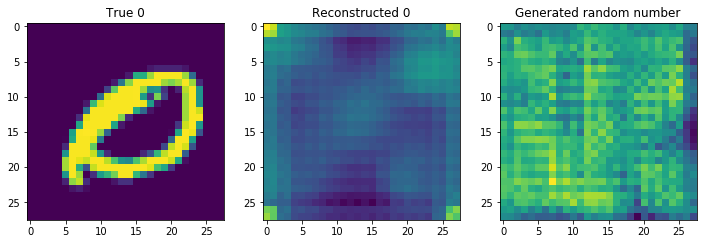

  Epoch: 1, total epcoh loss: 117.8788
epoch: 2, step:    0/469, total_loss:  14.4512 recon_loss:   0.3861, kl_loss:  12.9982 ssim_loss:   0.5335
epoch: 2, step:   93/469, total_loss:  12.9711 recon_loss:   0.3829, kl_loss:  11.4936 ssim_loss:   0.5473
epoch: 2, step:  186/469, total_loss:  11.6528 recon_loss:   0.3715, kl_loss:  10.1978 ssim_loss:   0.5417
epoch: 2, step:  279/469, total_loss:   9.9971 recon_loss:   0.3794, kl_loss:   8.5492 ssim_loss:   0.5342
epoch: 2, step:  372/469, total_loss:   8.9152 recon_loss:   0.3715, kl_loss:   7.4901 ssim_loss:   0.5268
epoch: 2, step:  465/469, total_loss:   7.9822 recon_loss:   0.3635, kl_loss:   6.5417 ssim_loss:   0.5385


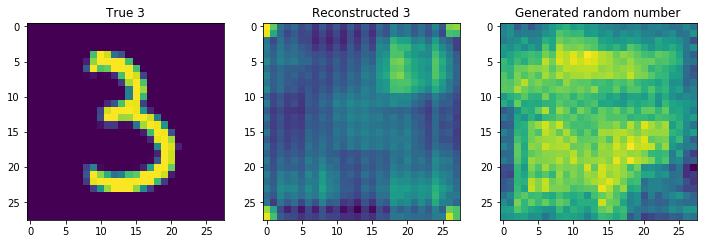

  Epoch: 2, total epcoh loss:  12.2742
epoch: 3, step:    0/469, total_loss:   8.0008 recon_loss:   0.3822, kl_loss:   6.5362 ssim_loss:   0.5412
epoch: 3, step:   93/469, total_loss:   7.4999 recon_loss:   0.3930, kl_loss:   6.0511 ssim_loss:   0.5279
epoch: 3, step:  186/469, total_loss:   7.1359 recon_loss:   0.3657, kl_loss:   5.6862 ssim_loss:   0.5420
epoch: 3, step:  279/469, total_loss:   6.7807 recon_loss:   0.3800, kl_loss:   5.3478 ssim_loss:   0.5264
epoch: 3, step:  372/469, total_loss:   6.7258 recon_loss:   0.3423, kl_loss:   5.2675 ssim_loss:   0.5580
epoch: 3, step:  465/469, total_loss:   5.6809 recon_loss:   0.3338, kl_loss:   4.2953 ssim_loss:   0.5259


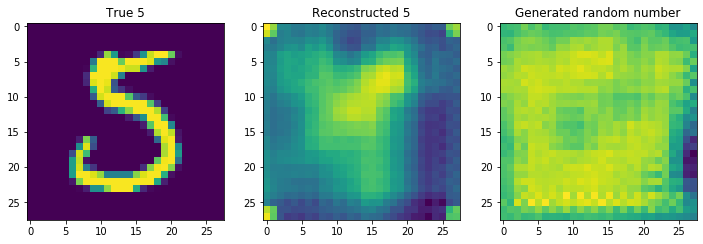

  Epoch: 3, total epcoh loss:   7.5949
epoch: 4, step:    0/469, total_loss:   5.1416 recon_loss:   0.3568, kl_loss:   3.7394 ssim_loss:   0.5227
epoch: 4, step:   93/469, total_loss:   6.1413 recon_loss:   0.3181, kl_loss:   4.7664 ssim_loss:   0.5284
epoch: 4, step:  186/469, total_loss:   4.6771 recon_loss:   0.3473, kl_loss:   3.2742 ssim_loss:   0.5278
epoch: 4, step:  279/469, total_loss:   4.9173 recon_loss:   0.3362, kl_loss:   3.5491 ssim_loss:   0.5160
epoch: 4, step:  372/469, total_loss:   4.1597 recon_loss:   0.3053, kl_loss:   2.8250 ssim_loss:   0.5147
epoch: 4, step:  465/469, total_loss:   3.7987 recon_loss:   0.2851, kl_loss:   2.5181 ssim_loss:   0.4978


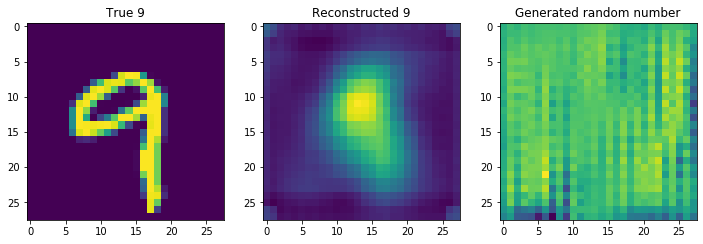

  Epoch: 4, total epcoh loss:   5.7148
epoch: 5, step:    0/469, total_loss:   3.6805 recon_loss:   0.2869, kl_loss:   2.3878 ssim_loss:   0.5029
epoch: 5, step:   93/469, total_loss:   4.2202 recon_loss:   0.2814, kl_loss:   2.9231 ssim_loss:   0.5078
epoch: 5, step:  186/469, total_loss:   3.9739 recon_loss:   0.3176, kl_loss:   2.6346 ssim_loss:   0.5108
epoch: 5, step:  279/469, total_loss:  10.2480 recon_loss:   0.3356, kl_loss:   8.7225 ssim_loss:   0.5950
epoch: 5, step:  372/469, total_loss:   6.4071 recon_loss:   0.2486, kl_loss:   5.1794 ssim_loss:   0.4895
epoch: 5, step:  465/469, total_loss:   4.5231 recon_loss:   0.2928, kl_loss:   3.3210 ssim_loss:   0.4546


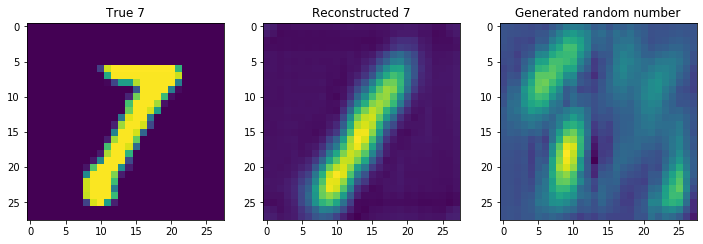

  Epoch: 5, total epcoh loss:   4.2649
epoch: 6, step:    0/469, total_loss:   3.5293 recon_loss:   0.2417, kl_loss:   2.4345 ssim_loss:   0.4266
epoch: 6, step:   93/469, total_loss:   2.8446 recon_loss:   0.2449, kl_loss:   1.7237 ssim_loss:   0.4380
epoch: 6, step:  186/469, total_loss:   4.0428 recon_loss:   0.2270, kl_loss:   2.9389 ssim_loss:   0.4385
epoch: 6, step:  279/469, total_loss:   3.0421 recon_loss:   0.2177, kl_loss:   2.0055 ssim_loss:   0.4095
epoch: 6, step:  372/469, total_loss:   3.0288 recon_loss:   0.2045, kl_loss:   2.0195 ssim_loss:   0.4024
epoch: 6, step:  465/469, total_loss:   2.4485 recon_loss:   0.1891, kl_loss:   1.5164 ssim_loss:   0.3715


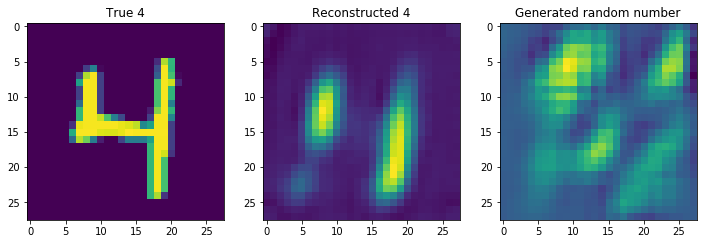

  Epoch: 6, total epcoh loss:   3.4440
epoch: 7, step:    0/469, total_loss:   2.4409 recon_loss:   0.2016, kl_loss:   1.4700 ssim_loss:   0.3847
epoch: 7, step:   93/469, total_loss:   2.9246 recon_loss:   0.1710, kl_loss:   2.0356 ssim_loss:   0.3590
epoch: 7, step:  186/469, total_loss:   7.8274 recon_loss:   0.2029, kl_loss:   6.7796 ssim_loss:   0.4224
epoch: 7, step:  279/469, total_loss:   2.0540 recon_loss:   0.1733, kl_loss:   1.1747 ssim_loss:   0.3530
epoch: 7, step:  372/469, total_loss:   2.2142 recon_loss:   0.1662, kl_loss:   1.3726 ssim_loss:   0.3377
epoch: 7, step:  465/469, total_loss:   1.8950 recon_loss:   0.1630, kl_loss:   1.0659 ssim_loss:   0.3331


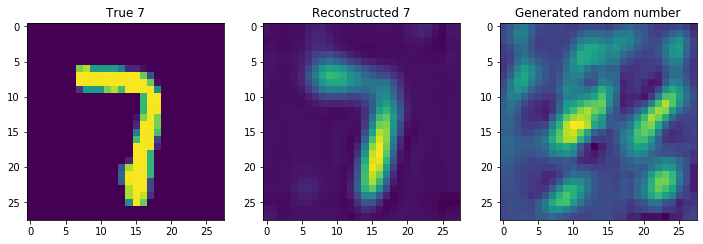

  Epoch: 7, total epcoh loss:   2.6752
epoch: 8, step:    0/469, total_loss:   1.8496 recon_loss:   0.1631, kl_loss:   1.0171 ssim_loss:   0.3347
epoch: 8, step:   93/469, total_loss:   2.0033 recon_loss:   0.1462, kl_loss:   1.2434 ssim_loss:   0.3069
epoch: 8, step:  186/469, total_loss:   1.8965 recon_loss:   0.1418, kl_loss:   1.1499 ssim_loss:   0.3024
epoch: 8, step:  279/469, total_loss:   2.0687 recon_loss:   0.1430, kl_loss:   1.3216 ssim_loss:   0.3021
epoch: 8, step:  372/469, total_loss:   1.5856 recon_loss:   0.1300, kl_loss:   0.8740 ssim_loss:   0.2908
epoch: 8, step:  465/469, total_loss:   1.7469 recon_loss:   0.1232, kl_loss:   1.0700 ssim_loss:   0.2768


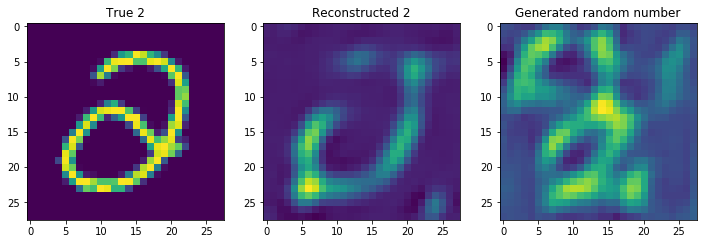

  Epoch: 8, total epcoh loss:   2.1760
epoch: 9, step:    0/469, total_loss:   1.5764 recon_loss:   0.1277, kl_loss:   0.8888 ssim_loss:   0.2800
epoch: 9, step:   93/469, total_loss:   2.0372 recon_loss:   0.1236, kl_loss:   1.3356 ssim_loss:   0.2890
epoch: 9, step:  186/469, total_loss:   1.8806 recon_loss:   0.1153, kl_loss:   1.2147 ssim_loss:   0.2753
epoch: 9, step:  279/469, total_loss:   1.6603 recon_loss:   0.1166, kl_loss:   1.0056 ssim_loss:   0.2691
epoch: 9, step:  372/469, total_loss:   2.4089 recon_loss:   0.1174, kl_loss:   1.7052 ssim_loss:   0.2932
epoch: 9, step:  465/469, total_loss:   1.5045 recon_loss:   0.1079, kl_loss:   0.8881 ssim_loss:   0.2542


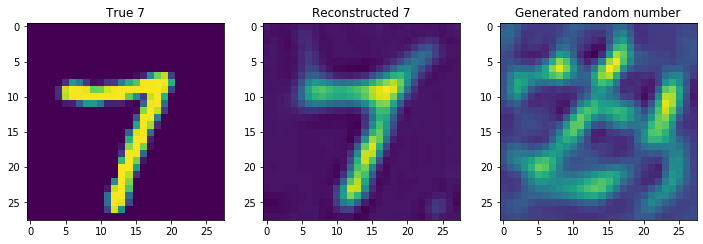

  Epoch: 9, total epcoh loss:   1.7987
epoch: 10, step:    0/469, total_loss:   1.4879 recon_loss:   0.1127, kl_loss:   0.8633 ssim_loss:   0.2559
epoch: 10, step:   93/469, total_loss:   2.5511 recon_loss:   0.1177, kl_loss:   1.8374 ssim_loss:   0.2980
epoch: 10, step:  186/469, total_loss:   1.7902 recon_loss:   0.1039, kl_loss:   1.1784 ssim_loss:   0.2539
epoch: 10, step:  279/469, total_loss:   1.4249 recon_loss:   0.0961, kl_loss:   0.8627 ssim_loss:   0.2331
epoch: 10, step:  372/469, total_loss:   1.3840 recon_loss:   0.0979, kl_loss:   0.8317 ssim_loss:   0.2272
epoch: 10, step:  465/469, total_loss:   1.0659 recon_loss:   0.0894, kl_loss:   0.5318 ssim_loss:   0.2224


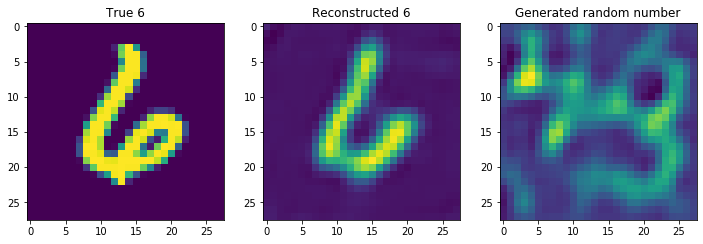

  Epoch: 10, total epcoh loss:   1.5104
epoch: 11, step:    0/469, total_loss:   1.0821 recon_loss:   0.0951, kl_loss:   0.5274 ssim_loss:   0.2298
epoch: 11, step:   93/469, total_loss:   2.7045 recon_loss:   0.1052, kl_loss:   2.0631 ssim_loss:   0.2681
epoch: 11, step:  186/469, total_loss:   1.1084 recon_loss:   0.0838, kl_loss:   0.6168 ssim_loss:   0.2039
epoch: 11, step:  279/469, total_loss:   1.0520 recon_loss:   0.0804, kl_loss:   0.5582 ssim_loss:   0.2067
epoch: 11, step:  372/469, total_loss:   1.0059 recon_loss:   0.0816, kl_loss:   0.5236 ssim_loss:   0.2004
epoch: 11, step:  465/469, total_loss:   1.0196 recon_loss:   0.0810, kl_loss:   0.5397 ssim_loss:   0.1994


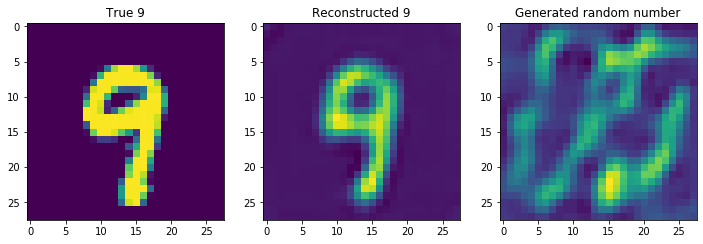

  Epoch: 11, total epcoh loss:   1.2646
epoch: 12, step:    0/469, total_loss:   0.8655 recon_loss:   0.0831, kl_loss:   0.3693 ssim_loss:   0.2066
epoch: 12, step:   93/469, total_loss:   1.2201 recon_loss:   0.0884, kl_loss:   0.7263 ssim_loss:   0.2027
epoch: 12, step:  186/469, total_loss:   2.7172 recon_loss:   0.1279, kl_loss:   1.9720 ssim_loss:   0.3087
epoch: 12, step:  279/469, total_loss:   0.9201 recon_loss:   0.0780, kl_loss:   0.4469 ssim_loss:   0.1976
epoch: 12, step:  372/469, total_loss:   0.8049 recon_loss:   0.0737, kl_loss:   0.3616 ssim_loss:   0.1848
epoch: 12, step:  465/469, total_loss:   0.9343 recon_loss:   0.0749, kl_loss:   0.4904 ssim_loss:   0.1845


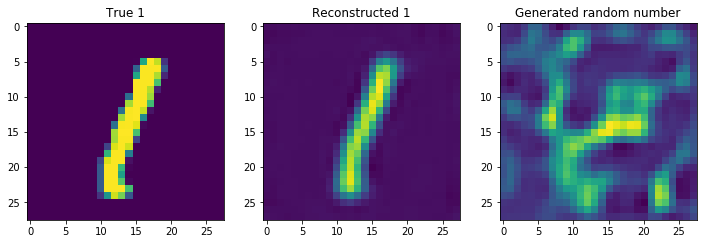

  Epoch: 12, total epcoh loss:   1.1280
epoch: 13, step:    0/469, total_loss:   0.7617 recon_loss:   0.0734, kl_loss:   0.3246 ssim_loss:   0.1819
epoch: 13, step:   93/469, total_loss:   0.7818 recon_loss:   0.0722, kl_loss:   0.3374 ssim_loss:   0.1861
epoch: 13, step:  186/469, total_loss:   0.6869 recon_loss:   0.0698, kl_loss:   0.2649 ssim_loss:   0.1761
epoch: 13, step:  279/469, total_loss:   0.8757 recon_loss:   0.0763, kl_loss:   0.4273 ssim_loss:   0.1861
epoch: 13, step:  372/469, total_loss:   0.6915 recon_loss:   0.0675, kl_loss:   0.2787 ssim_loss:   0.1726
epoch: 13, step:  465/469, total_loss:   0.7032 recon_loss:   0.0728, kl_loss:   0.2693 ssim_loss:   0.1805


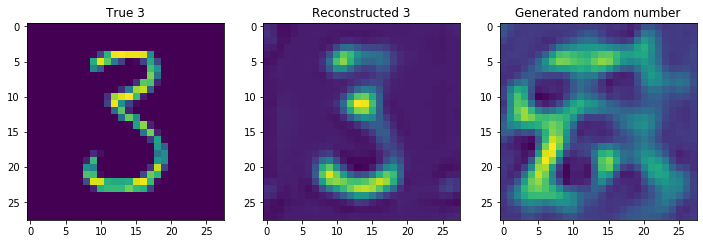

  Epoch: 13, total epcoh loss:   0.9667
epoch: 14, step:    0/469, total_loss:   0.6536 recon_loss:   0.0694, kl_loss:   0.2362 ssim_loss:   0.1740
epoch: 14, step:   93/469, total_loss:   0.6923 recon_loss:   0.0652, kl_loss:   0.2959 ssim_loss:   0.1656
epoch: 14, step:  186/469, total_loss:   1.2763 recon_loss:   0.0739, kl_loss:   0.8240 ssim_loss:   0.1892
epoch: 14, step:  279/469, total_loss:   0.7154 recon_loss:   0.0635, kl_loss:   0.3322 ssim_loss:   0.1598
epoch: 14, step:  372/469, total_loss:   0.6085 recon_loss:   0.0636, kl_loss:   0.2225 ssim_loss:   0.1612
epoch: 14, step:  465/469, total_loss:   0.5736 recon_loss:   0.0584, kl_loss:   0.2143 ssim_loss:   0.1504


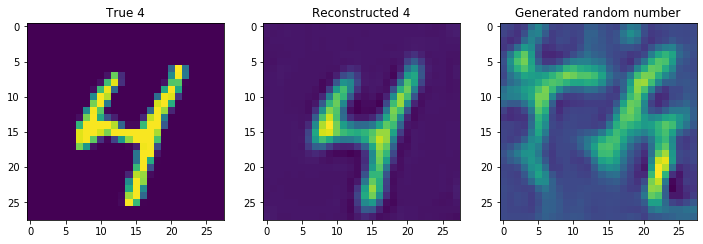

  Epoch: 14, total epcoh loss:   0.8165
epoch: 15, step:    0/469, total_loss:   0.5685 recon_loss:   0.0584, kl_loss:   0.2032 ssim_loss:   0.1534
epoch: 15, step:   93/469, total_loss:   0.6417 recon_loss:   0.0628, kl_loss:   0.2604 ssim_loss:   0.1592
epoch: 15, step:  186/469, total_loss:   0.5694 recon_loss:   0.0604, kl_loss:   0.1956 ssim_loss:   0.1567
epoch: 15, step:  279/469, total_loss:   0.5299 recon_loss:   0.0566, kl_loss:   0.1720 ssim_loss:   0.1506
epoch: 15, step:  372/469, total_loss:   0.5815 recon_loss:   0.0554, kl_loss:   0.2360 ssim_loss:   0.1450
epoch: 15, step:  465/469, total_loss:   0.5069 recon_loss:   0.0534, kl_loss:   0.1784 ssim_loss:   0.1376


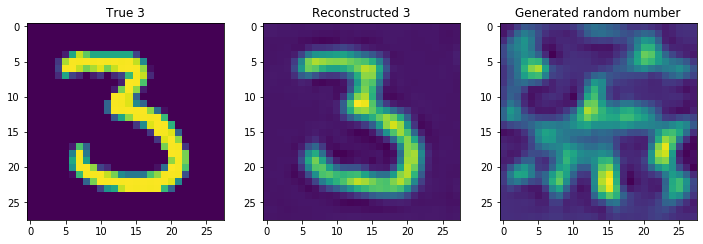

  Epoch: 15, total epcoh loss:   0.7281
epoch: 16, step:    0/469, total_loss:   0.4980 recon_loss:   0.0556, kl_loss:   0.1536 ssim_loss:   0.1444
epoch: 16, step:   93/469, total_loss:   1.5101 recon_loss:   0.0778, kl_loss:   0.9892 ssim_loss:   0.2216
epoch: 16, step:  186/469, total_loss:   0.5819 recon_loss:   0.0527, kl_loss:   0.2581 ssim_loss:   0.1355
epoch: 16, step:  279/469, total_loss:   1.1045 recon_loss:   0.0747, kl_loss:   0.6689 ssim_loss:   0.1805
epoch: 16, step:  372/469, total_loss:   0.5547 recon_loss:   0.0512, kl_loss:   0.2253 ssim_loss:   0.1391
epoch: 16, step:  465/469, total_loss:   0.4952 recon_loss:   0.0589, kl_loss:   0.1380 ssim_loss:   0.1491


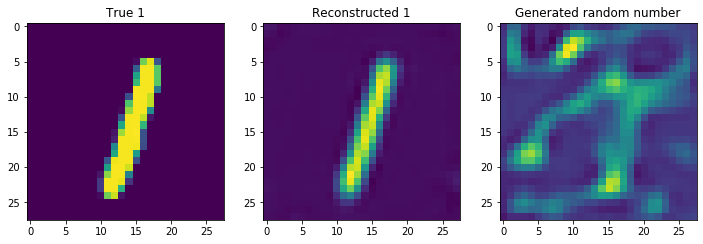

  Epoch: 16, total epcoh loss:   0.6847
epoch: 17, step:    0/469, total_loss:   0.4846 recon_loss:   0.0565, kl_loss:   0.1436 ssim_loss:   0.1422
epoch: 17, step:   93/469, total_loss:   0.5429 recon_loss:   0.0523, kl_loss:   0.2172 ssim_loss:   0.1367
epoch: 17, step:  186/469, total_loss:   0.6455 recon_loss:   0.0548, kl_loss:   0.3110 ssim_loss:   0.1399
epoch: 17, step:  279/469, total_loss:   0.4932 recon_loss:   0.0517, kl_loss:   0.1741 ssim_loss:   0.1337
epoch: 17, step:  372/469, total_loss:   0.4661 recon_loss:   0.0489, kl_loss:   0.1501 ssim_loss:   0.1335
epoch: 17, step:  465/469, total_loss:   0.9069 recon_loss:   0.0770, kl_loss:   0.3605 ssim_loss:   0.2347


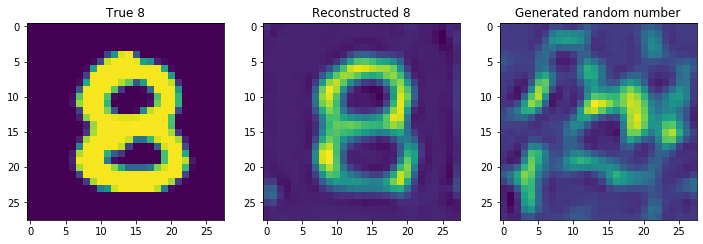

  Epoch: 17, total epcoh loss:   0.5587
epoch: 18, step:    0/469, total_loss:   1.2968 recon_loss:   0.1067, kl_loss:   0.6618 ssim_loss:   0.2642
epoch: 18, step:   93/469, total_loss:   0.7389 recon_loss:   0.0544, kl_loss:   0.3894 ssim_loss:   0.1475
epoch: 18, step:  186/469, total_loss:   0.3963 recon_loss:   0.0464, kl_loss:   0.1034 ssim_loss:   0.1233
epoch: 18, step:  279/469, total_loss:   0.5690 recon_loss:   0.0518, kl_loss:   0.2353 ssim_loss:   0.1409
epoch: 18, step:  372/469, total_loss:   0.5971 recon_loss:   0.0556, kl_loss:   0.2631 ssim_loss:   0.1392
epoch: 18, step:  465/469, total_loss:   0.5212 recon_loss:   0.0522, kl_loss:   0.1947 ssim_loss:   0.1372


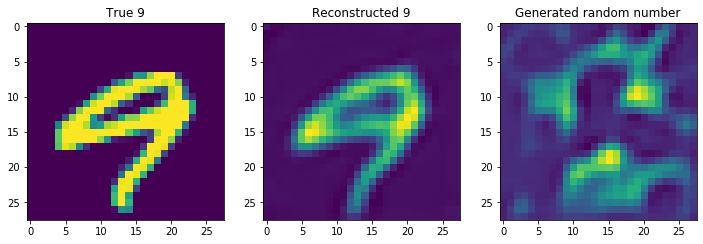

  Epoch: 18, total epcoh loss:   0.5223
epoch: 19, step:    0/469, total_loss:   0.4455 recon_loss:   0.0494, kl_loss:   0.1341 ssim_loss:   0.1310
epoch: 19, step:   93/469, total_loss:   0.4736 recon_loss:   0.0504, kl_loss:   0.1591 ssim_loss:   0.1321
epoch: 19, step:  186/469, total_loss:   0.4062 recon_loss:   0.0456, kl_loss:   0.1155 ssim_loss:   0.1226
epoch: 19, step:  279/469, total_loss:   0.4667 recon_loss:   0.0489, kl_loss:   0.1586 ssim_loss:   0.1296
epoch: 19, step:  372/469, total_loss:   0.3711 recon_loss:   0.0457, kl_loss:   0.0911 ssim_loss:   0.1172
epoch: 19, step:  465/469, total_loss:   0.3608 recon_loss:   0.0429, kl_loss:   0.0911 ssim_loss:   0.1134


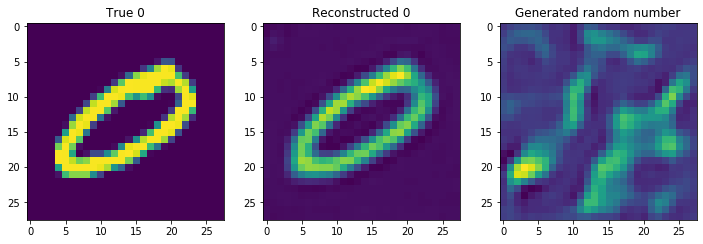

  Epoch: 19, total epcoh loss:   0.4837
epoch: 20, step:    0/469, total_loss:   0.3418 recon_loss:   0.0430, kl_loss:   0.0699 ssim_loss:   0.1145
epoch: 20, step:   93/469, total_loss:   0.3433 recon_loss:   0.0436, kl_loss:   0.0748 ssim_loss:   0.1125
epoch: 20, step:  186/469, total_loss:   0.3572 recon_loss:   0.0421, kl_loss:   0.0849 ssim_loss:   0.1151
epoch: 20, step:  279/469, total_loss:   0.3790 recon_loss:   0.0454, kl_loss:   0.0914 ssim_loss:   0.1211
epoch: 20, step:  372/469, total_loss:   0.4557 recon_loss:   0.0468, kl_loss:   0.1427 ssim_loss:   0.1331
epoch: 20, step:  465/469, total_loss:   0.8208 recon_loss:   0.0736, kl_loss:   0.4067 ssim_loss:   0.1703


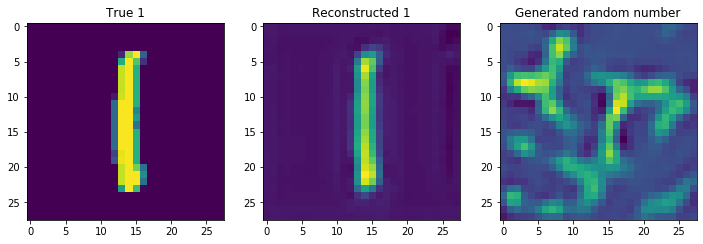

  Epoch: 20, total epcoh loss:   0.4513


In [339]:
#denoise
device = "cuda"
input_ch = 1
hidden_ch = 128
latent_ch=10
model = VariationalAutoEncoder(input_ch, hidden_ch, latent_ch).to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, verbose=True)
noise_factor = 0.5
plt.rcParams["figure.figsize"] = (12, 12)

for epoch in range(20):
    epoch_losses = []
    for i, batch in enumerate(data_loader):
        optim.zero_grad()
        data = batch[0].to(device)
        #noise = noise_factor * torch.normal(torch.ones_like(data), torch.ones_like(data))
        predict, mu, sigma = model(data)#+noise.to(device))
        total_loss, recon_loss, kl_loss, ssim_loss = vae_loss(data, predict, mu, sigma, ssim_weight=2.0)
        total_loss.backward()
        optim.step()
        epoch_losses.append(total_loss)
        if i % (len(data_loader)//5) == 0:
            print(f'epoch: {epoch+1}, step: {i:4}/{len(data_loader)}, total_loss: {total_loss.item():8.4f} '
            f'recon_loss: {recon_loss.item():8.4f}, kl_loss: {kl_loss.item():8.4f} '
            f'ssim_loss: {ssim_loss.item():8.4f}')
    
    epoch_loss = torch.mean(torch.stack(epoch_losses)).item()
    lr_scheduler.step(epoch_loss)
    model.eval()
    with torch.no_grad():
        item, label = next(iter(test_loader))
        fig, ax = plt.subplots(1, 3)
        sample = model(item.to(device))[0].view(28, 28).cpu().detach().numpy()
        ax[0].imshow(item.view(28, 28).numpy())
        ax[0].set_title(f"True {str(label.item())}")
        ax[1].imshow(sample)
        ax[1].set_title(f"Reconstructed {str(label.item())}")
        x = sampling(torch.zeros([1, latent_ch, 7, 7]), torch.ones([1, latent_ch, 7, 7]))
        x = model.decoder(x.to(device))
        ax[2].imshow(x.cpu().view(28, 28).numpy())
        ax[2].set_title(f"Generated random number")
        plt.show()
    model.train()
    print(f"  Epoch: {epoch+1}, total epcoh loss: {epoch_loss:8.4f}")

    torch.save(model.state_dict(), f'./conv_chkpt_conv_{epoch+1}.pth')

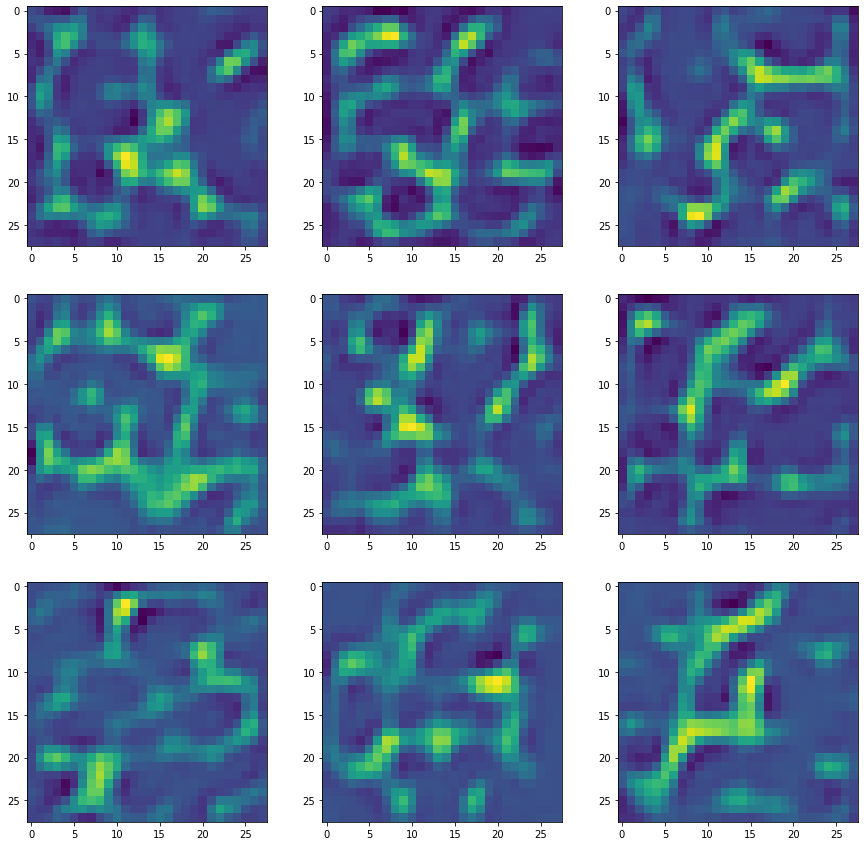

In [371]:
model.eval()
plt.rcParams["figure.figsize"] = (15, 15)
fig, ax = plt.subplots(3, 3)
for i in range(3):
    for j in range(3):
        with torch.no_grad():
            x = sampling(torch.zeros([1, latent_ch, 7, 7]), torch.ones([1, latent_ch, 7, 7]))
            x = model.decoder(x.to(device))
            ax[i][j].imshow(x.cpu().view(28, 28).numpy())
plt.show()